### Analysis software development v2 

Goal: establish smooth reading of the binary DAQ datafiles

In [1]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
from scipy.stats import norm

# import data handling class
from Na22Analysis import *
import pandas as pd

Select the runs to analyze

In [2]:
runs = ['C:/data/20220217_092209/']

Open a datafile and read the data

In [3]:
myNa22 = Na22Analysis(runs=runs)

DT5550:: no data files specified.... re-initialize before use


Loop over the data: either create the summary hd5 files or read them...

In [4]:
myNa22.process_data(max_files=9999,data='hd5')

Na22Analysis:: Begin processing data....
DT5550:: Data recorded with config:  C:/data/20220217_092209\config_20220217_092209.json
Na22Analysis:: create pandas dataframe for analysis.....
DT5550:: Data recorded with config:  C:/data/20220217_092209\config_20220217_092209.json
C:/data/20220217_092209\selected_data.hd5
Na22Analysis:: Processing data - Done....


#### Plot time lifetime

In [81]:
from scipy import special
from lmfit import Model, Parameters, Minimizer, report_fit

def delta_time(x, A0, A1, tau0, sigma, C, A2, tau2):
    #tau = params['tau']
    #sigma = params['sigma']
    #A = params['A']
    #C = params['C']
    
    lam = 1./tau0
    
    arg = -x**2/sigma**2/2
    fval = A0*np.exp(arg)/sigma/np.sqrt(2*np.pi)
    
    arg0 = -lam*(x-sigma**2*lam/2.)
    arg1 = (x-sigma**2*lam)/np.sqrt(2.)/sigma
    fval = fval+A1*np.exp(arg0)*(1+special.erf(arg1))/2
    
    lam = 1./tau2
    arg0 = -lam*(x-sigma**2*lam/2.)
    arg1 = (x-sigma**2*lam)/np.sqrt(2.)/sigma
    fval = fval+A2*np.exp(arg0)*(1+special.erf(arg1))/2

    #fval = fval + A2*np.exp(-x/tau2)*np.heaviside(x,0)
    
    fval = fval + C
    
    return fval


In [83]:
toffset=2.5
tt=np.array(myNa22.df['dt'][(myNa22.df['sdt']<10)&(abs(myNa22.df['epos']-1022)<100)]) - toffset

In [98]:
xr = (-500,1000)
bins = 500
cc = 140

y, xe = np.histogram(tt, bins=bins, range=xr)
x = .5 * (xe[:-1] + xe[1:])

[8.46431316e+06 6.41136874e+05 1.90528941e+00 1.87226703e+00
 1.66201736e+02 2.62852862e+02 7.22207016e+01]


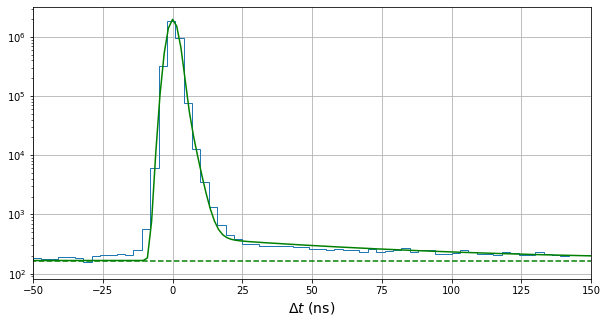

In [99]:
from scipy.optimize import curve_fit

plt.figure(figsize=(10,5))
popt,pcov = curve_fit(delta_time, x, y, sigma=np.sqrt(y), 
                      p0=[1e7, 5e5, 2.4, 2.3, 300, 350, 100], 
                      bounds=((-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0, 0), (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)))
#plt.errorbar(x,y,yerr=np.sqrt(y), marker='o', markersize=4, ls='none' ) 
plt.hist(tt,bins=bins, range=xr, histtype='step', linewidth=1)
xx = np.linspace(xr[0],xr[1],1000)
plt.grid()
plt.plot(xx,delta_time(xx, *popt), color='green')
plt.plot([xr[0],xr[1]],[popt[4],popt[4]], '--', color='green')
print(popt)
#plt.ylim([100,1000])
plt.yscale('log')
plt.xlim([-50,150])
plt.xlabel('$\Delta t$ (ns)',fontsize=14)
plt.show()

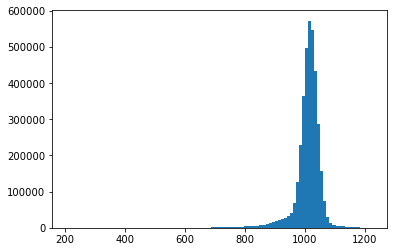

In [96]:
plt.hist(myNa22.df['epos'],bins=100)
plt.show()